In [1]:
import pickle

with open('testX.pkl', 'rb') as f:
    testX = pickle.load(f)


with open('testY.pkl', 'rb') as f:
    testY = pickle.load(f)


with open('le.pkl', 'rb') as f:
    le = pickle.load(f)


In [2]:
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

2021-09-15 15:36:05.767102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:

batch_size = 10


In [4]:
def metrics(model, batch_size=40):    
    predIdxs = model.predict(testX, batch_size=batch_size)
    predIdxs = np.argmax(predIdxs, axis=1)
    print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))
    modelLoss, modelAccuracy = model.evaluate(testX, testY)

    print('Test Loss is {}'.format(modelLoss))
    print('Test Accuracy is {}'.format(modelAccuracy ))
    class_names = ['Covid-19', 'Lung Opacity', 'Normal', 'Pneumonia']
    y_pred = model.predict(testX)
    print(class_names[np.argmax(y_pred[11])])
    x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
    Confusion_Matrix = pd.DataFrame(x,index=class_names, columns=class_names)

    sns.set(font_scale=1.5, color_codes=True, palette='deep')
    sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix')
    plt.show()

2021-09-15 15:36:06.909612: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 15:36:06.910255: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-15 15:36:06.937189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 15:36:06.937398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-09-15 15:36:06.937419: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-15 15:36:06.938374: I tensorflow/stream_executor/platfo

              precision    recall  f1-score   support

    Covid-19    0.97500   0.70124   0.81577       723
Lung Opacity    0.88508   0.85857   0.87162      1202
      Normal    0.84615   0.97646   0.90665      2039
   Pneumonia    0.98454   0.71004   0.82505       269

    accuracy                        0.87905      4233
   macro avg    0.92269   0.81158   0.85477      4233
weighted avg    0.88801   0.87905   0.87599      4233

133/133 [==============================] - 11s 73ms/step - loss: 0.1472 - acc: 0.8790
Test Loss is 0.1471656709909439
Test Accuracy is 0.8790456056594849
Lung Opacity


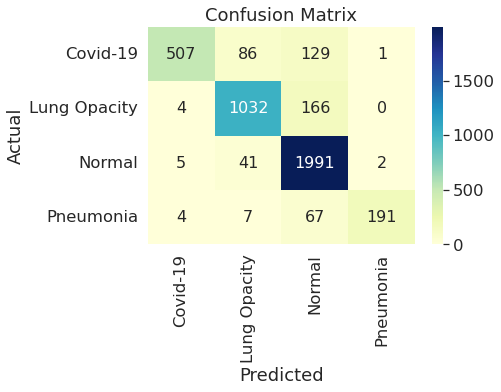

In [5]:
# model = keras.models.load_model('CNN_Covid19_Xray_V1.h5')
# metrics(model)
# model = keras.models.load_model('resnet50_model.h5')
# metrics(model)
model = keras.models.load_model('vgg16_model.h5')
metrics(model)
# model = keras.models.load_model('inc_history_model.h5')
# metrics(model)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

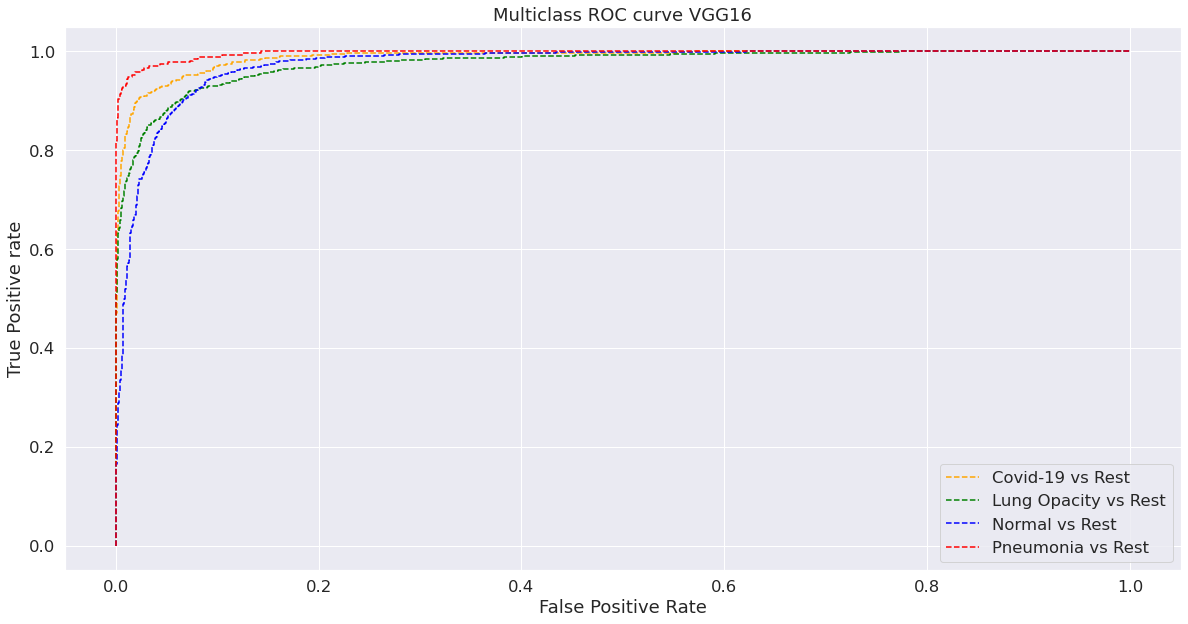

auc for Covid-19 = 0.9882052070157188
auc for Lung Opacity = 0.9752115000238797
auc for Normal = 0.9744776314912981
auc for Pneumonia = 0.9962431399322528


In [7]:
predIdxs = model.predict(testX, batch_size=batch_size)

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import sklearn
from sklearn.preprocessing import label_binarize

fpr, tpr, thresh = roc_curve(testY.argmax(axis=1),predIdxs.argmax(axis=1), pos_label=1)
random_probs = [0 for i in range(len(testY))]
p_fpr, p_tpr, _ = roc_curve(testY.argmax(axis=1), random_probs, pos_label=1)

class_names = ['Covid-19', 'Lung Opacity', 'Normal', 'Pneumonia']

auc_score = roc_auc_score(testY, predIdxs, multi_class='ovo')
auc_score

fpr = {}
tpr = {}
roc_auc ={}
y = label_binarize(testY, classes=[0, 1, 2,3])
n_classes = y.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], predIdxs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

plt.figure(figsize=(20,10))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label=le.classes_[0] +' vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label=le.classes_[1]+ ' vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label=le.classes_[2]+' vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label=le.classes_[3]+' vs Rest')

plt.title('Multiclass ROC curve VGG16')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

roc_auc

for i in roc_auc.keys():
    print("auc for " + str(le.classes_[i])+ ' = ' + str(roc_auc[i]))